# Predator-prey system with constant harvesting rate

In {cite}`Brauer@1979` the following predator-prey system with constant
harvesting rate is considered

```{math}
:label: eq:predatorpray
\begin{cases}
\begin{aligned}
\dot x &= rx\left(1-\frac x k\right) - y \frac x {e+x}, \\
\dot y &= y\left(-d+\frac x {e+x}\right) - h. \\
\end{aligned}
\end{cases}
```

Here the parameters have the following interpretations:
- $k$ is the carrying capacity of the prey population,
- $d$ is the death rate of the predator,
- $r$ is the intrinsic growth rate of the prey population,
- and $h$ is the harvesting rate. 

The function $x \mapsto \frac{x}{e+x}$ is often called the functional response
of Holling type II. The authors in {cite}`Xiao@1999` show the existence of a
Bogdanov-Takens bifurcation in {eq}`eq:predatorpray` and sketch the global
bifurcation diagram including the homoclinic curve which emanates from the
Bogdanov-Takens point.  We study the occurrence of homoclinic orbits that
emanate from the computed Bogdanov-Takens point using _MatCont_.

## Overview

In this demo we will

- Define an analytically derived Bogdanov-Takens point.
- Start continuation of the homoclinic branch emanating from the
  Bogdanov-Takens point in two parameters $(d,h)$ using the new homoclinic
  smooth orbital predictor from {cite}`Bosschaert@2021`.
- Compare the predicted and computed homoclinic bifurcation curve emanating
  from the Bogdanov-Takens point in parameters space.
- Compare a range of predictors for the homoclinic solutions emanating from the
  Bogdanov-Takens point with the corrected homoclinic solutions curve in
  phase-space.
- Create a convergence plot of the different homoclinic approximations
  derived in {cite}`Bosschaert@2021`.

## Load MatCont

Before we can start using __MatCont__ we need to add the main directory of
__MatCont,__ as well as various subdirectories of __MatCont,__ to the _MATLAB
search path_. This is done in the code below. The variable `matcont_home`
should point to the main directory of __MatCont.__

In [1]:
clear all
matcontpath = '../';
addpath(matcontpath)
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'LimitPointCycle'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'Utilities'])
set(groot, 'defaultTextInterpreter', 'LaTeX');
set(0,'defaultAxesFontSize',15)

## Set the odefile

Next we set the variable `odefile` to the _system file_ previously generated by
the notebook [PredatorPreyGenSym.ipynb](PredatorPreyGenSym.ipynb).

In [2]:
odefile=@PredatorPrey;

## Define Bogdanov-Takens point manually

There are two equilibrium points in {eq}`eq:predatorpray`. One is given by
```{math}
:label: eq:predatorpray_bt_point
\begin{aligned}
\begin{cases}
x_1 &= \frac{\sqrt{9 d^2+8 d h-12 d-8 h+4}-d+2}{2-2 d}, \\
x_2 &= -\frac{\sqrt{9 d^2+8 d h-12 d-8 h+4}+d (4 h+3)-4 h-2}{4 (d-1)^2}.
\end{cases}
\end{aligned}
```
By evaluating the Jacobian of {eq}`eq:predatorpray` 

$$
J = \begin{pmatrix}
 \frac{x y}{(x+1)^2}-\frac{y}{x+1}-x+1 & -\frac{x}{x+1} \\
 \left(\frac{1}{x+1}-\frac{x}{(x+1)^2}\right) y & \frac{x}{x+1}-d \\
\end{pmatrix}
$$

at the equilibrium {eq}`eq:predatorpray_bt_point` and subsequently solving for
a double zero of the characteristic equation of $J$ for $(d,h)$ yields

$$
\begin{aligned}
d &= \frac{1}{9} \left(8-\frac{11}{\sqrt[3]{548-18 \sqrt{894}}}-\frac{\sqrt[3]{274-9 \sqrt{894}}}{2^{2/3}}\right), \\
h &= \frac{93\ 2^{2/3}-9 \sqrt[6]{2} \sqrt{447}-975 \sqrt[3]{\frac{2}{274-9 \sqrt{894}}}+\frac{36\ 2^{5/6} \sqrt{447}}{\sqrt[3]{274-9 \sqrt{894}}}+30 \sqrt[3]{274-9 \sqrt{894}}}{88\ 2^{2/3}+16 \sqrt[3]{274-9 \sqrt{894}}+8 \sqrt[3]{2} \left(274-9 \sqrt{894}\right)^{2/3}}
.
\end{aligned}
$$

In [3]:
d = (1/9).*(8+(-11).*(548+(-18).*894.^(1/2)).^(-1/3)+(-1).*2.^(-2/3).* ...
(274+(-9).*894.^(1/2)).^(1/3));
h = (93.*2.^(2/3)+(-9).*2.^(1/6).*447.^(1/2)+(-975).*(2.*(274+(-9).* ...
    894.^(1/2)).^(-1)).^(1/3)+36.*2.^(5/6).*447.^(1/2).*(274+(-9).* ...
    894.^(1/2)).^(-1/3)+30.*(274+(-9).*894.^(1/2)).^(1/3)).*(88.*2.^( ...
    2/3)+16.*(274+(-9).*894.^(1/2)).^(1/3)+8.*2.^(1/3).*(274+(-9).* ...
    894.^(1/2)).^(2/3)).^(-1);
x = (1/2).*((-2)+d).*((-1)+d).^(-1);
y = (1/8).*((-1)+d).^(-2).*(8+(-18).*d+9.*d.^2);
bt.x = [x; y];
bt.par = [d; h];

To refer to the parameters throughout the script we create a __cell array__ of
strings containing the parameter names. This is then converted into a
__struct__. This allows us to refer to the parameters as `ind.parametername`,
similar as done in _DDE-BifTool_.

In [4]:
parnames = {'d', 'h'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});

## Continue homoclinic curve emanating from the Bogdanov-Takens point

To continue the homoclinic curve emanating from the Bogdanov-Takens point we
use the functions `BT_Hom_set_options` and `init_BT_Hom` to obtain an initial
approximation to the homoclinic solution (`hom_x`) as well as a tangent vector
to the discretized homoclinic solution (`hom_v`) as described in
{ref}`initial-prediction-Homoclinic-orbit`. 

In [5]:
ap = [ind.d, ind.h];
BToptions = BT_Hom_set_options();
[hom_x, hom_v] = init_BT_Hom(odefile, bt,  ap, BToptions);
opt = contset;
opt.MaxStepsize = 5;
opt.Singularities = 0;
opt.MaxNumPoints = 200;
homoclinic_br = cont(@homoclinic, hom_x, hom_v, opt);

Center manifold coefficients' accuracy: 9.992007e-16
BT normal form coefficients:
a=1.798257e-01,	 b=-3.782866e-01
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 0.0753982
The initial half-return time T: 86.8246
The initial distance eps0: 0.000144111
The initial distance eps1: 4.47679e-05
first point found
tangent vector to first point found
Current step size too small (point 118)
elapsed time  = 6.3 secs
npoints curve = 118


## Compare predicted with computed parameters

Now that we have obtained a curve of homoclinic orbits (`homoclinic_br`) we
compare the computed curve in parameter space with the predicted curve we
construct below. To do so, we use the function `BT_nmfm_orbital` to obtain the
smooth orbital normal form coefficients, i.e. $a$ and $b$, and the coefficients
of the transformation $K$ between the parameters of the system and the parameters
of the smooth orbital normal form on the center manifold, see
{cite}`Bosschaert@2021`. By using the transformation $K$ as given in
{cite}`Al-Hdaibat@2016` where $K_{11}$ is not included for the second order
approximation we see that including $K_{11}$ as done in {cite}`Bosschaert@2021`
does indeed lead to a better approximation.

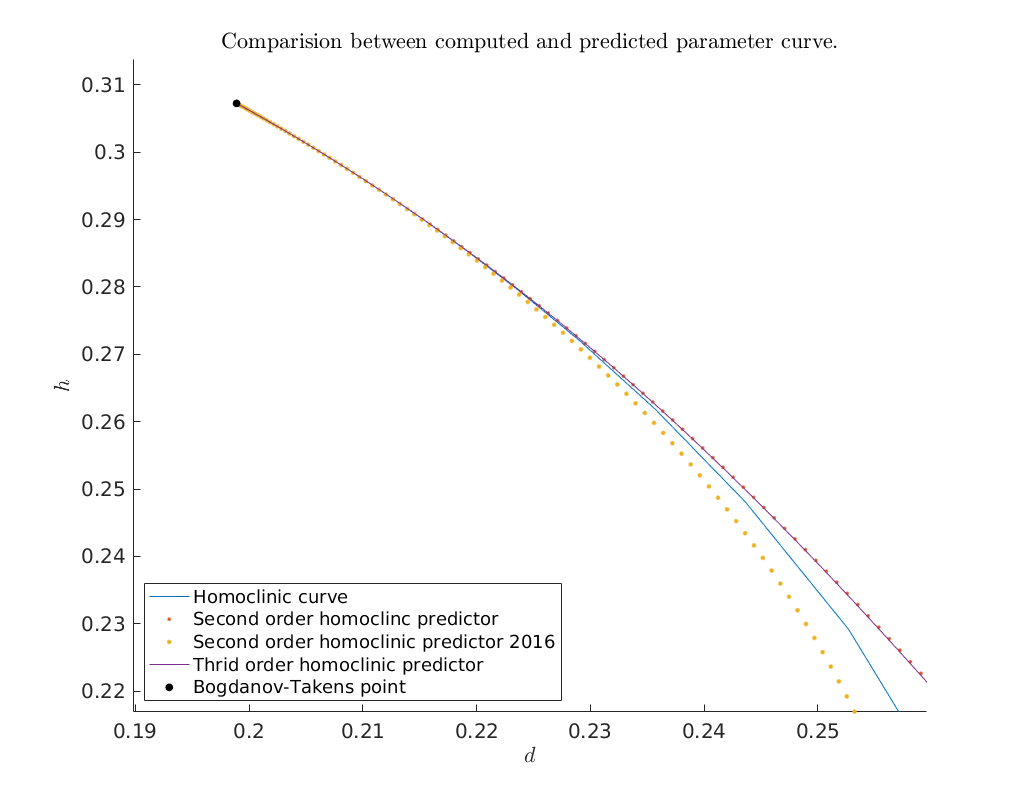

In [10]:
%plot --width 1024 --height 800
hold on
global homds
% plot computed parameter curve
plot(homoclinic_br(homds.PeriodIdx+1,:), ...
     homoclinic_br(homds.PeriodIdx+2,:));
% Bogdanov-Takens parameter-dependent normal form coefficients
bt = BT_nmfm_orbital(odefile, bt, ap, BToptions);
a   = bt.nmfm.a;
b   = bt.nmfm.b;
K10 = bt.nmfm.K10;
K01 = bt.nmfm.K01;
K02 = bt.nmfm.K02;
K11 = bt.nmfm.K11;
K03 = bt.nmfm.K03;
% construct predictor as in the paper
eps = linspace(0, 0.4);
beta1 = -4*a^3/b^4*eps.^4;
tau0  = 10/7;
tau2  = 288/2401;
beta2 = a/b*(tau0 + tau2*eps.^2).*eps.^2;
alpha = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2 + 1/6*K03.*beta2.^3;
alphaSecondOrder = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2;
alpha = bt.par(ap) + alpha;
alphaSecondOrder = bt.par(ap) + alphaSecondOrder;
alpha2016 = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2;
alpha2016 = bt.par(ap) + alpha2016;
% plot currect predictor
plot(alphaSecondOrder(1,:), alphaSecondOrder(2,:), '.', 'MarkerSize', 7)
plot(alpha2016(1,:), alpha2016(2,:), '.', 'MarkerSize', 10)
plot(alpha(1,:), alpha(2,:), '-', 'MarkerSize', 10)
% plot Bogdanov-Takens point
plot(bt.par(ind.d), bt.par(ind.h), '.k', 'MarkerSize', 20)
% set labels and legend
xlabel('$d$')
ylabel('$h$')
legend({'Homoclinic curve', 'Second order homoclinc predictor', ...
    'Second order homoclinic predictor 2016', ...
    'Thrid order homoclinic predictor', ...
    'Bogdanov-Takens point'}, 'Location', 'SouthWest')
title('Comparision between computed and predicted parameter curve.')
axis([0.1898    0.2596    0.2169    0.3137])

## Bifurcation diagram in $(x,y)$ phase-space

To obtain an impression of the  homoclinic solutions we plot the computed
homoclinic orbits in $(x,y)$ phase-space.


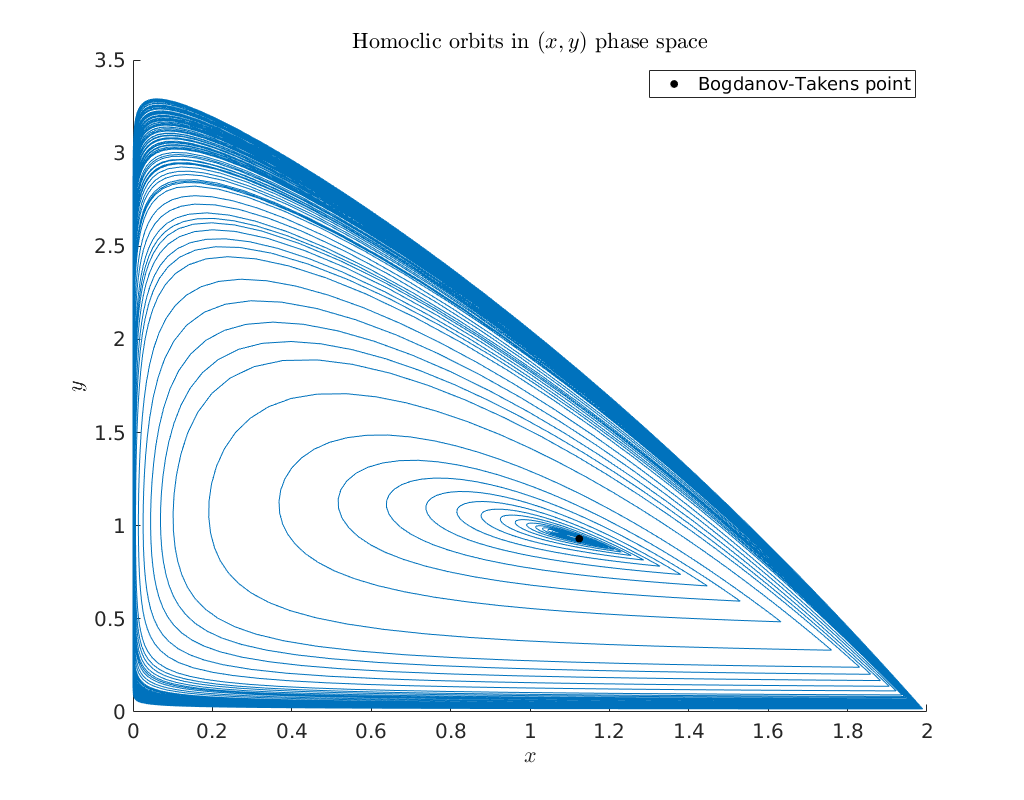

In [7]:
hold on
plot(homoclinic_br(homds.coords(1:homds.nphase:end), 1:end), ...
     homoclinic_br(homds.coords(2:homds.nphase:end), 1:end), ...
     'Color', [0 0.4470 0.7410], 'HandleVisibility', 'Off')
xlabel('$x$')
ylabel('$y$')
plot(bt.x(1), bt.x(2), '.k' ,'MarkerSize', 20)
legend('Bogdanov-Takens point', 'Location', 'NorthEast')
title('Homoclic orbits in $(x,y)$ phase space')

### Predictors of orbits for various epsilons

Below we compute for a large range of amplitudes the predicted and corrected
homoclinic solutions and compare them in phase space. We see that even with an
amplitude of `1` the predicted homoclinic orbit is still very close.

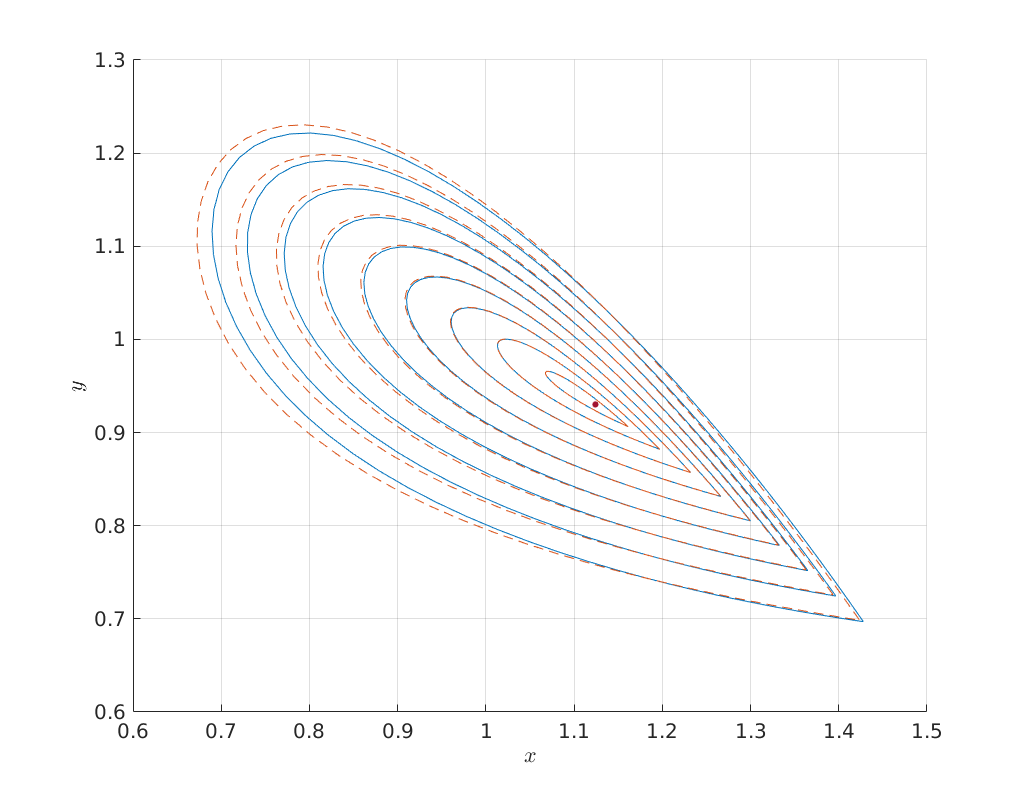

In [8]:
options = BT_Hom_set_options();
options.messages = false;
options.correct = false;
options.TTolerance = 1.0e-05;

amplitudes = linspace(1.0e-03, 1,10);
XPredicted = zeros(330,length(amplitudes));
XCorrected = zeros(330,length(amplitudes));
for j=1:length(amplitudes)
  options.amplitude = amplitudes(j);
  [x_pred, v0] = init_BT_Hom(odefile, bt, ap, options);
  XPredicted(:,j) = x_pred;
  try
    XCorrected(:,j) = newtcorr(x_pred, v0);
  catch
    warning('Didn''t convergence to homoclinic solution')
  end
end

hold on
cm = lines;
plot(XPredicted(homds.coords(1:homds.nphase:end),1:10), ...
     XPredicted(homds.coords(2:homds.nphase:end),1:10), ...
      'color', cm(1,:))
plot(XCorrected(homds.coords(1:homds.nphase:end),1:10), ...
     XCorrected(homds.coords(2:homds.nphase:end),1:10), ...
      '--', 'color', cm(2,:))
plot(bt.x(1), bt.x(2), '.', 'MarkerSize', 16)
xlabel('$x$')
ylabel('$y$')
grid on

## Convergence plot

We finish this notebook with a log-log convergence plot comparing the different
third order homoclinic approximation methods derived in {cite}`Bosschaert@2021`
to approximate the homoclinic solutions near the first Bogdanov-Takens point.
On the abscissa is the amplitude $A_0$ and on the ordinate the relative error
$\delta$ between the constructed solution (`x_pred`) to the defining system for the
homoclinic orbit and the Newton corrected solution (`x_corrected`).

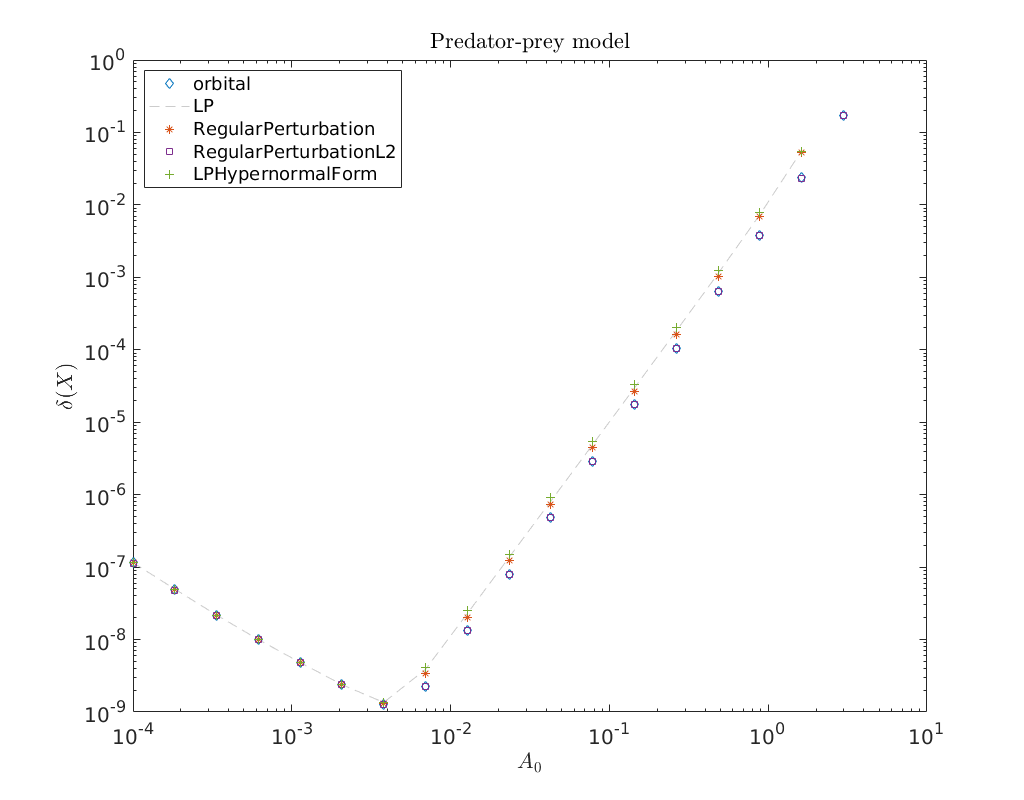

In [9]:
BToptions = BT_Hom_set_options();
BToptions.TTolerance = 1e-05;
BToptions.messages = false;
BToptions.correct = false;

amplitudes = logspace(-4, 1, 20);
methodList = {'orbital', 'LP', 'RegularPerturbation', ...
    'RegularPerturbationL2', 'LPHypernormalForm'};
relativeErrors = {};
for i=1:length(methodList)
    BToptions.method = methodList{i};
    relativeErrors{i} = zeros(size(amplitudes));
    for j=1:length(amplitudes)
    BToptions.amplitude = amplitudes(j);
    [x_pred, v0] = init_BT_Hom(odefile, bt, ap, BToptions);
    try
        x_corrected = newtcorr(x_pred, v0);
        relativeErrors{i}(j) = norm(x_corrected-x_pred)/norm(x_corrected);
    catch
        warning('Did not converge.')
        continue
    end
  end
end

cm = lines();
loglog(amplitudes, relativeErrors{1}(:), 'd', ...
       amplitudes, relativeErrors{2}(:), '--', ...
       amplitudes, relativeErrors{3}(:), '*', ...
       amplitudes, relativeErrors{4}(:), 's', ...
       amplitudes, relativeErrors{5}(:), '+')
legend(methodList, 'Location', 'NorthWest')
title('Predator-prey model')
xlabel('$A_0$')
ylabel('$\delta(X)$')
ax = gca;
ax.ColorOrder = [cm(1,:); [0.8 0.8 0.8]; cm(2,:); cm(4,:); cm(5,:)];